In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.dates as dates

import os 
import random
from contextlib import contextmanager
from time import time
from tqdm import tqdm

import plotly.express as px 
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

import lightgbm as lgbm
import category_encoders as ce 
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype='uint8')[y]

In [3]:
df0 = pd.read_csv('./input/coffee.csv')
print(len(df0))

5671


In [4]:
data = df0.reset_index(drop=True)
display(data)

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD
...,...,...,...,...,...,...,...
5666,2022-05-11,204.05,220.45,204.05,219.90,29972,USD
5667,2022-05-12,217.90,218.50,212.55,215.30,18989,USD
5668,2022-05-13,215.90,216.85,209.65,212.90,19974,USD
5669,2022-05-16,224.00,224.00,223.50,225.80,5,USD


In [5]:
data['Year'] = data['Date'].apply(lambda x: int(x[0:4]))
data['Month'] = data['Date'].apply(lambda x: int(x[5:7]))
data['Year-Month'] = data['Date'].apply(lambda x: x[0:7])
data['Date'] = pd.to_datetime(data['Date'])
display(data)


,Date,Open,High,Low,Close,Volume,Currency,Year,Month,Year-Month
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD,2000,1,2000-01
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD,2000,1,2000-01
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD,2000,1,2000-01
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD,2000,1,2000-01
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD,2000,1,2000-01
...,...,...,...,...,...,...,...,...,...,...
5666,2022-05-11,204.05,220.45,204.05,219.90,29972,USD,2022,5,2022-05
5667,2022-05-12,217.90,218.50,212.55,215.30,18989,USD,2022,5,2022-05
5668,2022-05-13,215.90,216.85,209.65,212.90,19974,USD,2022,5,2022-05
5669,2022-05-16,224.00,224.00,223.50,225.80,5,USD,2022,5,2022-05


In [6]:
data['Close shift1'] = data['Close'].shift(1)
data['Open - Close shift1'] = data['Open'] - data['Close shift1']


data['High 5day max']=data['High'].rolling(window=5).max()
data['Low 5day min']=data['Low'].rolling(window=5).min()
data['5-day profit max'] = data['High 5day max'] - data['Low 5day min']      

data['MA3']=data['Close'].rolling(window=3).mean()
data['MA4']=data['Close'].rolling(window=4).mean()
data['MA5']=data['Close'].rolling(window=5).mean()
data['MA8']=data['Close'].rolling(window=8).mean()
data['MA10']=data['Close'].rolling(window=10).mean()
data['MA25']=data['Close'].rolling(window=25).mean()
data['MA75']=data['Close'].rolling(window=75).mean()

data['MA3 slope']=(data['MA3']-data['MA3'].shift(5))/5
data['MA4 slope']=(data['MA4']-data['MA4'].shift(5))/5
data['MA5 slope']=(data['MA5']-data['MA5'].shift(5))/5
data['MA8 slope']=(data['MA8']-data['MA8'].shift(5))/5
data['MA10 slope']=(data['MA10']-data['MA10'].shift(5))/5
data['MA25 slope']=(data['MA25']-data['MA25'].shift(5))/5
data['MA75 slope']=(data['MA75']-data['MA75'].shift(5))/5

data['Annual Growth Rate'] = data['MA25']*100/data['MA25'].shift(252)

In [7]:
data.head()

,Date,Open,High,Low,Close,Volume,Currency,Year,Month,Year-Month,...,MA25,MA75,MA3 slope,MA4 slope,MA5 slope,MA8 slope,MA10 slope,MA25 slope,MA75 slope,Annual Growth Rate
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD,2000,1,2000-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD,2000,1,2000-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD,2000,1,2000-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD,2000,1,2000-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD,2000,1,2000-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
fig = make_subplots(specs=[[{'secondary_y':False}]])
fig.add_trace(go.Scatter(x=data['Date'], y=data['Close'], name='Close'), secondary_y=False)
fig.add_trace(go.Scatter(x=data['Date'], y=data['High'], name='High'), secondary_y=False)
fig.add_trace(go.Scatter(x=data['Date'], y=data['Low'], name='Low'), secondary_y=False)
fig.update_layout(autosize=False, width=700, height=400, title_text='Daily change')
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text='USD', secondary_y=False)
fig.show()


In [9]:
fig=make_subplots(specs=[[{"secondary_y":False}]])
fig.add_trace(go.Scatter(x=data['Date'],y=data['MA25'],name='MA25'),secondary_y=False,)
fig.add_trace(go.Scatter(x=data['Date'],y=data['MA75'],name='MA75'),secondary_y=False,)
fig.update_layout(autosize=False,width=700,height=400,title_text="Moving Average")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="USD",secondary_y=False)
fig.show()

In [10]:
fig=make_subplots(specs=[[{"secondary_y":False}]])
fig.add_trace(go.Scatter(x=data['Date'],y=data['Annual Growth Rate'],name='Annual Growth Rate'),secondary_y=False,)
fig.update_layout(autosize=False,width=700,height=400,title_text='Annual Growth Rate(%)')
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="%",secondary_y=False)
fig.show()

In [11]:
fig=make_subplots(specs=[[{"secondary_y":False}]])
fig.add_trace(go.Scatter(x=data['Date'],y=data['Open - Close shift1'],name='Open - Close shift1'),secondary_y=False,)
fig.update_layout(autosize=False,width=700,height=400,title_text="Open - Close shift1")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="USD",secondary_y=False)
fig.show()

In [12]:
fig=make_subplots(specs=[[{"secondary_y":False}]])
fig.add_trace(go.Scatter(x=data['Date'],y=data['5-day profit max'],name='5-day profit max'),secondary_y=False,)
fig.update_layout(autosize=False,width=700,height=400,title_text="5-day profit max")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="USD",secondary_y=False)
fig.show()

In [16]:
data.corr().sort_values(by='Volume')

,Open,High,Low,Close,Volume,Year,Month,Close shift1,Open - Close shift1,High 5day max,...,MA25,MA75,MA3 slope,MA4 slope,MA5 slope,MA8 slope,MA10 slope,MA25 slope,MA75 slope,Annual Growth Rate
Month,-0.013025,-0.013428,-0.011887,-0.013252,-0.101244,-0.040401,1.000000,-0.013821,0.032585,-0.013358,...,-0.016298,-0.013771,0.021840,0.022590,0.023012,0.022326,0.019088,0.007451,-0.015425,0.010192
Open - Close shift1,0.081888,0.080965,0.080717,0.080239,-0.031101,0.109259,0.032585,0.058256,1.000000,0.070068,...,0.066711,0.067998,0.012898,0.003009,-0.001815,-0.005326,-0.008915,-0.008271,0.004086,0.006296
Annual Growth Rate,0.530463,0.532569,0.529721,0.531123,-0.014795,0.078311,0.010192,0.531197,0.006296,0.535008,...,0.521383,0.450602,0.018737,0.022824,0.027501,0.045233,0.059489,0.209504,0.528185,1.000000
MA75 slope,0.268039,0.270743,0.265863,0.268987,0.026464,0.051581,-0.015425,0.268388,0.004086,0.268886,...,0.202326,0.061867,0.208419,0.237219,0.264345,0.337409,0.381267,0.625354,1.000000,0.528185
MA10 slope,0.101798,0.106908,0.101061,0.105966,0.042577,0.009756,0.019088,0.102179,-0.008915,0.092134,...,-0.028507,-0.055129,0.637587,0.714916,0.787714,0.960521,1.000000,0.602970,0.381267,0.059489
MA25 slope,0.150408,0.151731,0.148249,0.150426,0.042805,0.019955,0.007451,0.150856,-0.008271,0.149328,...,0.043563,-0.053565,0.300107,0.350018,0.397493,0.526142,0.602970,1.000000,0.625354,0.209504
MA3 slope,0.066231,0.073648,0.068103,0.075372,0.042811,0.005928,0.021840,0.066035,0.012898,0.033925,...,-0.038733,-0.046107,1.000000,0.976158,0.927515,0.729903,0.637587,0.300107,0.208419,0.018737
MA4 slope,0.071185,0.077918,0.072135,0.078704,0.047194,0.005955,0.022590,0.071232,0.003009,0.043717,...,-0.038299,-0.047717,0.976158,1.000000,0.980161,0.818097,0.714916,0.350018,0.237219,0.022824
MA5 slope,0.076125,0.082446,0.076529,0.082560,0.049732,0.006214,0.023012,0.076295,-0.001815,0.053426,...,-0.037596,-0.049287,0.927515,0.980161,1.000000,0.892819,0.787714,0.397493,0.264345,0.027501
MA8 slope,0.091835,0.097497,0.091358,0.096681,0.050498,0.008013,0.022326,0.092115,-0.005326,0.078582,...,-0.033544,-0.053587,0.729903,0.818097,0.892819,1.000000,0.960521,0.526142,0.337409,0.045233


# **Target Setting**

In [17]:
data1 = data.copy()
data = data1.dropna()
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5395 entries, 276 to 5670
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 5395 non-null   datetime64[ns]
 1   Open                 5395 non-null   float64       
 2   High                 5395 non-null   float64       
 3   Low                  5395 non-null   float64       
 4   Close                5395 non-null   float64       
 5   Volume               5395 non-null   int64         
 6   Currency             5395 non-null   object        
 7   Year                 5395 non-null   int64         
 8   Month                5395 non-null   int64         
 9   Year-Month           5395 non-null   object        
 10  Close shift1         5395 non-null   float64       
 11  Open - Close shift1  5395 non-null   float64       
 12  High 5day max        5395 non-null   float64       
 13  Low 5day min         5395 non-n

In [18]:
target = ['5-day profit max']
target0 = '5 - day profit max'

dataY = data1[target[0]]
dataX = data1.drop([target[0], 'Currency', 'Date', 'Year-Month'], axis=1)
df_columns = list(dataX.columns)
print(df_columns)

trainX = np.array(dataX)
trainY = np.array(dataY)
train_df = pd.DataFrame(trainX)
train_df.columns = df_columns

['Open', 'High', 'Low', 'Close', 'Volume', 'Year', 'Month', 'Close shift1', 'Open - Close shift1', 'High 5day max', 'Low 5day min', 'MA3', 'MA4', 'MA5', 'MA8', 'MA10', 'MA25', 'MA75', 'MA3 slope', 'MA4 slope', 'MA5 slope', 'MA8 slope', 'MA10 slope', 'MA25 slope', 'MA75 slope', 'Annual Growth Rate']


In [19]:
def create_numeric_feature(input_df: pd.DataFrame):
    use_columns = df_columns
    return input_df[use_columns].copy()

In [20]:
class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):
        
        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        
        self.format_str = format_str
        self.logger = logger
        self.start = None 
        self.end = None 
        
    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start
    
    def __enter__(self):
        self.start = time()
        
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [21]:
def to_feature(input_df):
    
    processors = [
        create_numeric_feature
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)
            
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [22]:
train_feat_df = to_feature(train_df)

100%|██████████| 1/1 [00:00<00:00, 165.92it/s]

createcreate_numeric_feature  0.003[s]


In [23]:
train_feat_df

,Open,High,Low,Close,Volume,Year,Month,Close shift1,Open - Close shift1,High 5day max,...,MA25,MA75,MA3 slope,MA4 slope,MA5 slope,MA8 slope,MA10 slope,MA25 slope,MA75 slope,Annual Growth Rate
0,61.70,62.40,61.40,62.00,4310.0,2001.0,2.0,61.75,-0.05,65.00,...,65.4380,68.184667,-0.446667,-0.4700,-0.5320,-0.71000,-0.7090,-0.11440,-0.316000,57.098232
1,62.25,63.20,62.10,62.65,7044.0,2001.0,2.0,62.00,0.25,63.40,...,65.4100,67.898000,-0.350000,-0.3625,-0.3980,-0.58250,-0.6960,-0.09440,-0.325733,57.232605
2,62.00,62.65,61.85,62.30,6179.0,2001.0,2.0,62.65,-0.65,63.20,...,65.3280,67.682667,-0.243333,-0.2825,-0.3060,-0.43500,-0.5870,-0.07360,-0.307600,57.332421
3,62.25,63.90,62.25,62.80,7787.0,2001.0,2.0,62.30,-0.05,63.90,...,65.2860,67.463333,-0.023333,-0.1525,-0.2020,-0.34125,-0.4620,-0.05520,-0.280800,57.494364
4,63.50,64.00,62.25,62.80,7704.0,2001.0,2.0,62.80,0.70,64.00,...,65.2460,67.260000,0.083333,0.0350,-0.0800,-0.21750,-0.3150,-0.05000,-0.250800,57.622538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5390,204.05,220.45,204.05,219.90,29972.0,2022.0,5.0,203.80,0.25,222.90,...,221.3984,229.647467,-1.688667,-1.8715,-1.5112,-1.00700,-1.1106,-0.64840,-0.376133,160.071722
5391,217.90,218.50,212.55,215.30,18989.0,2022.0,5.0,219.90,-2.00,220.45,...,220.9064,229.346133,-1.133333,-1.3640,-1.5752,-0.94525,-0.9396,-0.71000,-0.376800,158.898032
5392,215.90,216.85,209.65,212.90,19974.0,2022.0,5.0,215.30,0.60,220.45,...,220.3764,228.999467,-0.026667,-0.7275,-0.9932,-0.80400,-0.7956,-0.68840,-0.355467,157.745233
5393,224.00,224.00,223.50,225.80,5.0,2022.0,5.0,212.90,11.10,224.00,...,220.1424,228.916133,1.346667,0.9650,0.2060,-0.43950,-0.3132,-0.55680,-0.272000,156.818920


# **Modeling**

In [24]:
def fit_lgbm(X, y, cv, 
             params: dict=None,
             verbose: int=50):
    if params is None:
        params = {}
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={}'.format(i)):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=100,
                    verbose=verbose)
            
        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()
        
    score = mean_squared_error(y, oof_pred) ** .5
    print('#' * 50)
    print('Finished | Whole RMSLE: {:.4f}'.format(score))
    
    return oof_pred, models
    

In [27]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [28]:
y = trainY
ydf = pd.DataFrame(y)
ydf

,0
0,3.70
1,2.10
2,1.90
3,2.60
4,2.60
...,...
5390,20.60
5391,18.15
5392,18.15
5393,21.70


C:\Users\arsal\AppData\Local\Temp/ipykernel_13116/4043763975.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\arsal\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

c:\Users\arsal\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[500]	valid_0's rmse: 1.60541
[1000]	valid_0's rmse: 1.51332
[1500]	valid_0's rmse: 1.49136
[2000]	valid_0's rmse: 1.48338
[2500]	valid_0's rmse: 1.47958
[3000]	valid_0's rmse: 1.47801
[3500]	valid_0's rmse: 1.47728
[4000]	valid_0's rmse: 1.47702
fit fold=0 4.371[s]
Fold 0 RMSLE: 1.4770



c:\Users\arsal\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

c:\Users\arsal\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[500]	valid_0's rmse: 1.65648
[1000]	valid_0's rmse: 1.56639
[1500]	valid_0's rmse: 1.54518
[2000]	valid_0's rmse: 1.53636
[2500]	valid_0's rmse: 1.53239
[3000]	valid_0's rmse: 1.53081
[3500]	valid_0's rmse: 1.5301
fit fold=1 3.893[s]
Fold 1 RMSLE: 1.5300



c:\Users\arsal\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

c:\Users\arsal\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[500]	valid_0's rmse: 1.60665
[1000]	valid_0's rmse: 1.52732
[1500]	valid_0's rmse: 1.50816
[2000]	valid_0's rmse: 1.50051
[2500]	valid_0's rmse: 1.49686
[3000]	valid_0's rmse: 1.49518
[3500]	valid_0's rmse: 1.49431
fit fold=2 3.614[s]
Fold 2 RMSLE: 1.4943



c:\Users\arsal\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

c:\Users\arsal\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[500]	valid_0's rmse: 1.58274
[1000]	valid_0's rmse: 1.49313
[1500]	valid_0's rmse: 1.46778
[2000]	valid_0's rmse: 1.46021
[2500]	valid_0's rmse: 1.45549
[3000]	valid_0's rmse: 1.45355
[3500]	valid_0's rmse: 1.45243
fit fold=3 4.468[s]
Fold 3 RMSLE: 1.4521



c:\Users\arsal\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

c:\Users\arsal\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[500]	valid_0's rmse: 1.53746
[1000]	valid_0's rmse: 1.45902
[1500]	valid_0's rmse: 1.43698
[2000]	valid_0's rmse: 1.42782
[2500]	valid_0's rmse: 1.42376
[3000]	valid_0's rmse: 1.42179
[3500]	valid_0's rmse: 1.42074
fit fold=4 3.883[s]
Fold 4 RMSLE: 1.4207

##################################################
Finished | Whole RMSLE: 1.4753


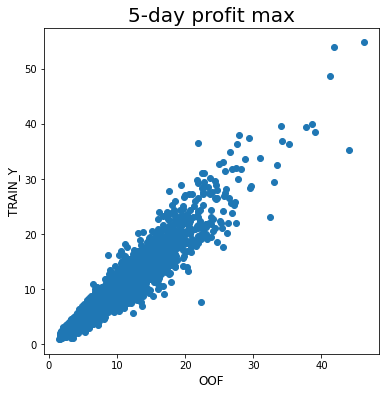

In [30]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=42)
    ydfi = ydf.iloc[:,i]
    y = np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i], fontsize=20)
    ax.set_xlabel('OOF', fontsize=12)
    ax.set_ylabel('TRAIN_Y', fontsize=12)
    ax.scatter(oof, y)

# **Visualize**

In [31]:
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)
        
    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False)\
        .index[:50]
        
    orders = order.tolist()
    print(orders)
    
    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    ax.grid()
    fig.tight_layout()
    
    return fig, ax, orders